# CNV Analysis

In [1]:
import cPickle
import datetime
import glob
import os
import random
import re
import subprocess

import cdpybio as cpb
from ipyparallel import Client
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import pybedtools as pbt
import scipy.stats as stats
import seaborn as sns
import statsmodels as sms
import statsmodels.api as sm
import statsmodels.formula.api
import statsmodels.formula.api as smf
import vcf as pyvcf

import cardipspy as cpy
import ciepy

%matplotlib inline

import socket
if socket.gethostname() == 'fl-hn1' or socket.gethostname() == 'fl-hn2':
    pbt.set_tempdir('/frazer01/home/cdeboever/tmp')
    
outdir = os.path.join(ciepy.root, 'output',
                      'cnv_analysis')
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output',
                              'cnv_analysis')
cpy.makedir(private_outdir)

In [2]:
fn = os.path.join(ciepy.root, 'output', 'input_data', 'rsem_tpm.tsv')
tpm = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'rnaseq_metadata.tsv')
rna_meta = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'subject_metadata.tsv')
subject_meta = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'wgs_metadata.tsv')
wgs_meta = pd.read_table(fn, index_col=0)

gene_info = pd.read_table(cpy.gencode_gene_info, index_col=0)
gene_info['ensembl_id'] = [x.split('.')[0] for x in gene_info.index]

genes = pbt.BedTool(cpy.gencode_gene_bed)

In [3]:
fn = os.path.join(ciepy.root, 'output', 'cnv_processing', 'cnv_info.tsv')
cnv_info = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'private_output', 'cnv_processing', 'mcnvs.tsv')
mcnvs = pd.read_table(fn, index_col=0)

In [4]:
fn = os.path.join(ciepy.root, 'output', 'eqtl_input', 'variant_regions.bed')
variant_regions = pbt.BedTool(fn)
fn = os.path.join(ciepy.root, 'output', 'eqtl_input', 'tpm_log_filtered_phe_std_norm_peer_resid.tsv')
eqtl_tpm = pd.read_table(fn, index_col=0)
eqtl_tpm = eqtl_tpm[(gene_info.ix[eqtl_tpm.index, 'chrom'] != 'chrX') & 
                    (gene_info.ix[eqtl_tpm.index, 'chrom'] != 'chrY') &
                    (gene_info.ix[eqtl_tpm.index, 'chrom'] != 'chrM')]
fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 'qvalues.tsv')
qvalues = pd.read_table(fn, index_col=0)

## mCNVs eQTLs

I want to test for an association between mCNVs and gene expression. I'm going to start
by using unrelated individuals. There are genetically unrelated people in families (for
instance the parents in a trio are unrelated) but for now I'll just take one person from
each family.

### mCNV samples

In [5]:
eqtl_samples = rna_meta[rna_meta.in_eqtl]
mcnv_subject_meta = subject_meta.ix[eqtl_samples.subject_id].drop_duplicates(subset=['family_id'])
mcnv_samples = eqtl_samples[eqtl_samples.subject_id.apply(lambda x: x in mcnv_subject_meta.index)]

In [6]:
mcnv_samples_by_wgs = mcnv_samples.copy(deep=True)
mcnv_samples_by_wgs['rna_id'] = mcnv_samples_by_wgs.index
mcnv_samples_by_wgs.index = mcnv_samples_by_wgs.wgs_id
mcnv_samples_by_wgs = mcnv_samples_by_wgs.merge(subject_meta, left_on='subject_id', right_index=True)

### mCNV filtering

I'll filter the mCNVs based on the samples I'm using here.

In [7]:
mcnvs_f = mcnvs[mcnv_samples.wgs_id]
b = mcnvs_f.apply(lambda x: x.value_counts().max() < mcnvs_f.shape[1] - np.floor(mcnvs_f.shape[1] * 0.05), axis=1)
mcnvs_f = mcnvs_f[b]

In [8]:
t = cnv_info.ix[mcnvs_f.index]
s = '\n'.join(t.chrom + '\t' + t.start.astype(str) + '\t' + t.end.astype(str) + 
              '\t' + t.name) + '\n'
mcnvs_bt = pbt.BedTool(s, from_string=True)
mcnvs_bt = mcnvs_bt.sort()

In [9]:
# Let's find out which mCNVs overlap the variant regions for the genes.
res = mcnvs_bt.intersect(variant_regions, sorted=True, wo=True)
df = res.to_dataframe()
df['gene'] = df.thickEnd.apply(lambda x: x.split('_')[0])
# I'll make a mapping from gene to mCNV.
gene_to_mcnv = pd.Series(df.name.values, index=df.gene)

In [10]:
eqtl_tpm_f = eqtl_tpm[mcnv_samples.wgs_id]
eqtl_tpm_f = cpb.general.transform_standard_normal(eqtl_tpm_f)

In [11]:
mcnvs_f.to_csv(os.path.join(private_outdir, 'filtered_mcnvs.tsv'), sep='\t')

### Regression

In [12]:
def mcnv_data(gene):
    cnvs = gene_to_mcnv[gene]
    if type(cnvs) is pd.core.series.Series:
        cnvs = list(cnvs)
    else:
        cnvs = [cnvs]
    data = mcnvs_f.ix[cnvs].T
    data['exp'] = eqtl_tpm_f.ix[gene, data.index].values
    data['sex'] = (mcnv_samples_by_wgs.ix[data.index, 'sex'] == 'M').values
    return data

def mcnv_regression(gene):
    cnvs = gene_to_mcnv[gene]
    if type(cnvs) is pd.core.series.Series:
        cnvs = list(cnvs)
    else:
        cnvs = [cnvs]
    data = mcnvs_f.ix[cnvs].T
    data['exp'] = eqtl_tpm_f.ix[gene, data.index].values
    data['sex'] = (mcnv_samples_by_wgs.ix[data.index, 'sex'] == 'M').values
    data = mcnv_data(gene)
    results = {}
    for cnv in cnvs:
        results[cnv] = statsmodels.formula.api.ols('exp ~ {} + sex'.format(cnv), data=data).fit()
    return results

In [13]:
se = gene_to_mcnv.ix[set(gene_to_mcnv.index) & set(eqtl_tpm_f.index)]
print('{:,} total tests'.format(se.shape[0]))
print('{:,} distinct genes'.format(len(set(se.index))))
print('{:,} distinct mCNVs'.format(len(set(se.values))))

6,522 total tests
1,374 distinct genes
361 distinct mCNVs


In [14]:
fn = os.path.join(outdir, 'results.pickle')
if not os.path.exists(fn):
    ind = list(set(gene_to_mcnv.index) & set(eqtl_tpm_f.index))
    gene_results = []
    for g in ind:
        gene_results.append(mcnv_regression(g))
    with open(fn , 'w') as f:
        cPickle.dump(gene_results, f)
else:
    gene_results = cPickle.load(open(fn))

In [15]:
fn = os.path.join(outdir, 'reg_results.tsv')
if not os.path.exists(fn):
    g = []
    c = []
    p = []
    b = []
    for i,d in enumerate(gene_results):
        for k in d.keys():
            g.append(ind[i])
            c.append(k)
            p.append(d[k].pvalues[k])
            b.append(d[k].params[k])
    reg_results = pd.DataFrame({'gene':g, 'cnv':c, 'pvalue':p, 'beta':b})
    r = sms.sandbox.stats.multicomp.multipletests(reg_results.pvalue, method='fdr_bh')
    reg_results['bh_pvalue'] = r[1]
    reg_results['bh_sig'] = r[0]
    reg_results = reg_results.merge(cnv_info, left_on='cnv', right_index=True).drop(['name'], axis=1)
    reg_results = reg_results.merge(gene_info, left_on='gene', right_index=True, suffixes=['', '_gene'])
    reg_results['overlap_gene'] = (((reg_results.start > reg_results.start_gene) & 
                                    (reg_results.start < reg_results.end_gene)) | 
                                   ((reg_results.end > reg_results.start_gene) & 
                                    (reg_results.end < reg_results.end_gene)))
    a = reg_results.end - reg_results.start_gene
    b = reg_results.start - reg_results.end_gene
    t = pd.DataFrame([a,b]).T
    ta = t.abs()
    tv = t[ta.apply(lambda x: x == x.min(), axis=1)]
    tv = tv.fillna(0).sum(axis=1)
    reg_results['dist_to_gene'] = tv
    reg_results.ix[reg_results.overlap_gene, 'dist_to_gene'] = 0
    reg_results.to_csv(fn, sep='\t')
else:
    reg_results = pd.read_table(fn, index_col=0)
sig = reg_results[reg_results.bh_sig]
sig.sort_values(by='pvalue', inplace=True)

In [17]:
sns.set_context('talk', font_scale=1.5)

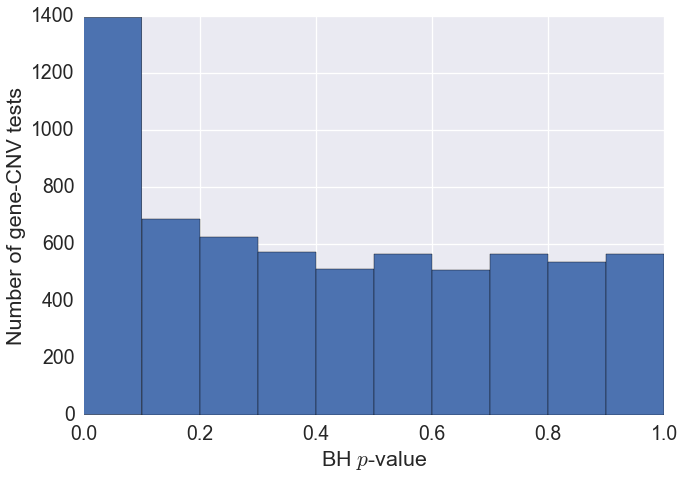

In [19]:
reg_results.pvalue.hist()
plt.ylabel('Number of gene-CNV tests')
plt.xlabel('$p$-value');

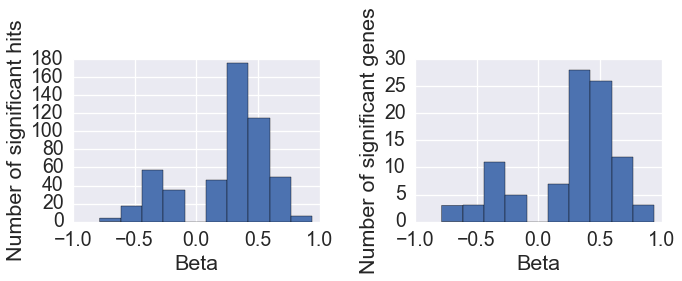

In [20]:
fig,axs = plt.subplots(1, 2, figsize=(10, 4))
ax = axs[0]
sig.beta.hist(ax=ax)
ax.set_xticks([-1, -0.5, 0, 0.5, 1])
ax.set_ylabel('Number of significant hits')
ax.set_xlabel('Beta');

ax = axs[1]
sig.drop_duplicates(subset=['gene']).beta.hist(ax=axs[1])
ax.set_xticks([-1, -0.5, 0, 0.5, 1])
ax.set_ylabel('Number of significant genes')
ax.set_xlabel('Beta');
plt.tight_layout()

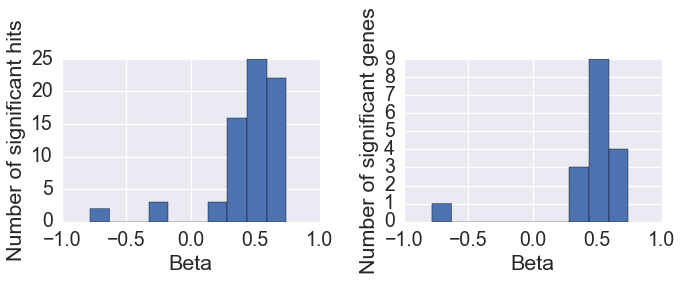

In [24]:
fig,axs = plt.subplots(1, 2, figsize=(10, 4))
ax = axs[0]
sig[sig.overlap_gene].beta.hist(ax=ax)
ax.set_xticks([-1, -0.5, 0, 0.5, 1])
ax.set_ylabel('Number of significant hits')
ax.set_xlabel('Beta');

ax = axs[1]
t = sig.drop_duplicates(subset=['gene'])
t[t.overlap_gene].beta.hist(ax=axs[1])
ax.set_xticks([-1, -0.5, 0, 0.5, 1])
ax.set_ylabel('Number of significant genes')
ax.set_xlabel('Beta');
plt.tight_layout()

In [23]:
len(set(sig.ix[sig.overlap_gene, 'gene']))

24

In [21]:
sig.overlap_gene.value_counts()

False    433
True      71
Name: overlap_gene, dtype: int64

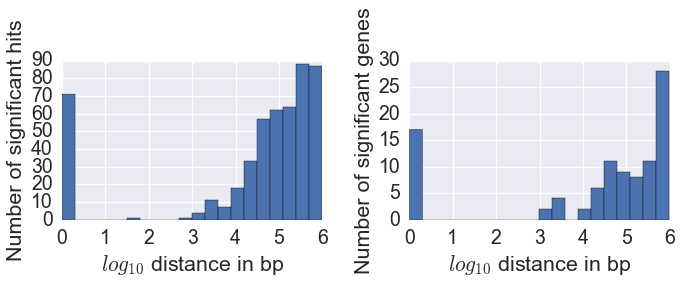

In [33]:
fig,axs = plt.subplots(1, 2, figsize=(10, 4))
ax = axs[0]
(np.log10(sig.dist_to_gene.abs() + 1)).hist(ax=ax, bins=20)
ax.set_ylabel('Number of significant hits')
ax.set_xlabel('$log_{10}$ distance in bp');

ax = axs[1]
(np.log10(sig.drop_duplicates(subset=['gene']).dist_to_gene.abs() + 1)).hist(ax=axs[1], bins=20)
ax.set_ylabel('Number of significant genes')
ax.set_xlabel('$log_{10}$ distance in bp');
plt.tight_layout()

In [39]:
sig.shape

(504, 22)

In [38]:
len(set(sig.cnv))

147

In [18]:
len(set(sig.gene))

98

In [35]:
def plot_results(gene):
    data = mcnv_data(gene)
    s = sig[sig.gene == gene]
    for c in s.cnv:
        sns.lmplot(x=c, y='exp', data=data, x_jitter=0.2)
        plt.ylabel(gene_info.ix[gene, 'gene_name'])

In [36]:
s = sig[sig.gene == sig.gene.drop_duplicates().values[0]]

In [37]:
s

,beta,cnv,gene,pvalue,bh_pvalue,bh_sig,chrom,start,end,length,...,chrom_gene,start_gene,end_gene,strand,gene_status,source,level,ensembl_id,overlap_gene,dist_to_gene
3213,0.740610,CNV_16_70154848_70158883,ENSG00000090857.9,1.031313e-32,6.726226e-29,True,chr16,70154848,70158883,4035,...,chr16,70147528,70195203,+,KNOWN,HAVANA,2,ENSG00000090857,True,0
3218,0.710188,CNV_16_70176968_70179967,ENSG00000090857.9,6.140049e-32,1.101833e-28,True,chr16,70176968,70179967,2999,...,chr16,70147528,70195203,+,KNOWN,HAVANA,2,ENSG00000090857,True,0
3216,0.705862,CNV_16_70157068_70167631,ENSG00000090857.9,7.502269e-32,1.101833e-28,True,chr16,70157068,70167631,10563,...,chr16,70147528,70195203,+,KNOWN,HAVANA,2,ENSG00000090857,True,0
3212,0.701116,CNV_16_70171012_70179575,ENSG00000090857.9,8.272624e-32,1.101833e-28,True,chr16,70171012,70179575,8563,...,chr16,70147528,70195203,+,KNOWN,HAVANA,2,ENSG00000090857,True,0
3214,0.700988,CNV_16_70157485_70167071,ENSG00000090857.9,8.447048e-32,1.101833e-28,True,chr16,70157485,70167071,9586,...,chr16,70147528,70195203,+,KNOWN,HAVANA,2,ENSG00000090857,True,0
3215,0.707006,CNV_16_70155587_70159071,ENSG00000090857.9,2.839485e-31,3.086521e-28,True,chr16,70155587,70159071,3484,...,chr16,70147528,70195203,+,KNOWN,HAVANA,2,ENSG00000090857,True,0
3211,0.704071,CNV_16_70180235_70192932,ENSG00000090857.9,8.626511e-31,8.037443e-28,True,chr16,70180235,70192932,12697,...,chr16,70147528,70195203,+,KNOWN,HAVANA,2,ENSG00000090857,True,0
3217,0.666551,CNV_16_70185825_70196032,ENSG00000090857.9,4.715355e-29,3.417061e-26,True,chr16,70185825,70196032,10207,...,chr16,70147528,70195203,+,KNOWN,HAVANA,2,ENSG00000090857,True,0


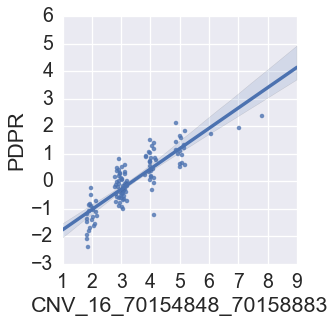

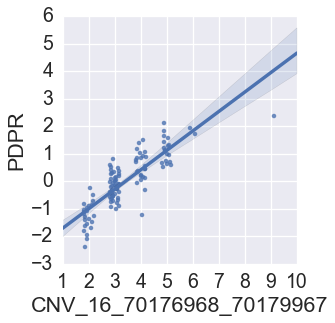

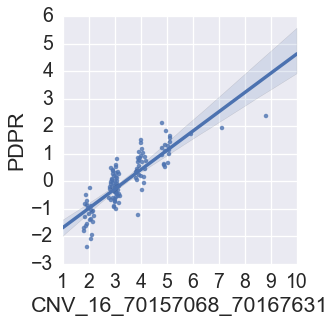

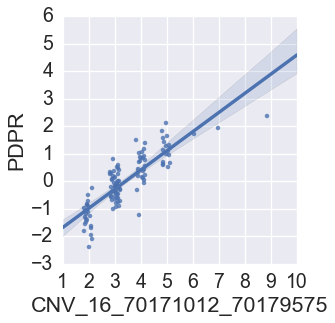

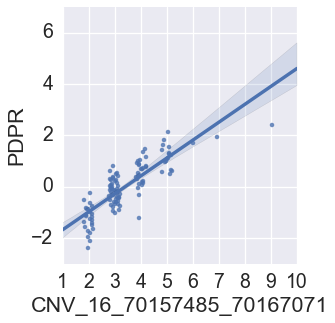

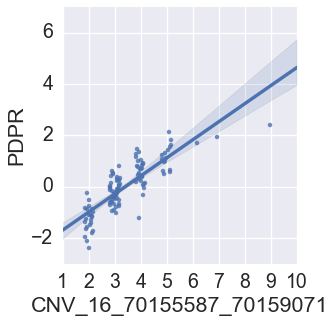

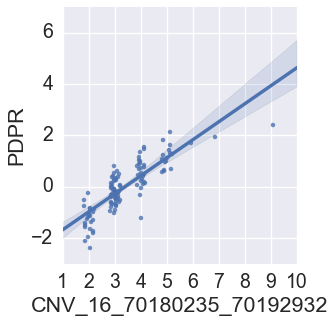

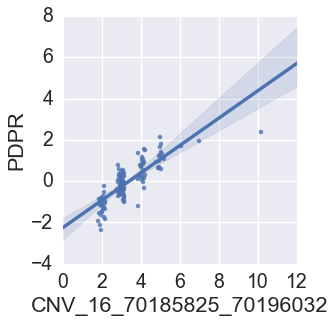

In [38]:
plot_results(sig.gene.drop_duplicates().values[0])

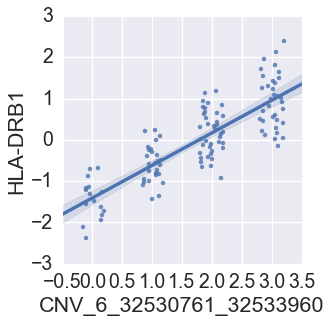

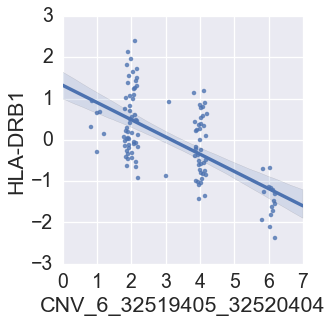

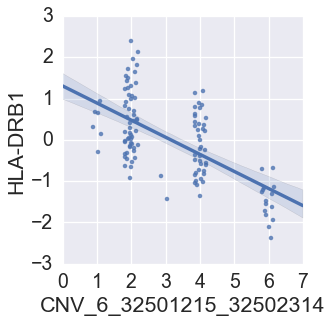

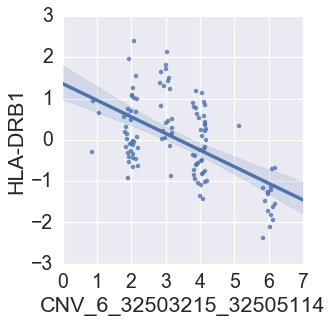

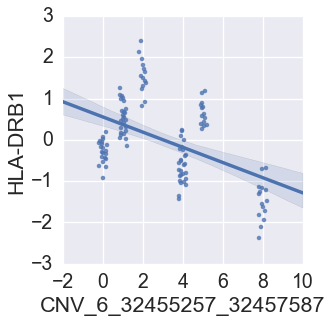

In [40]:
plot_results(sig.gene.drop_duplicates().values[1])

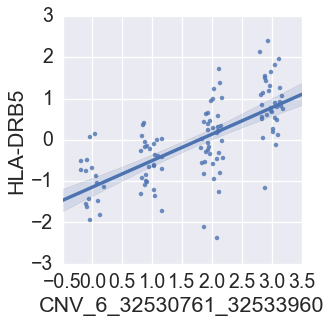

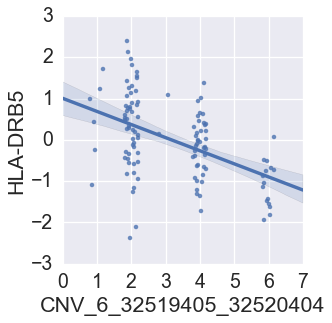

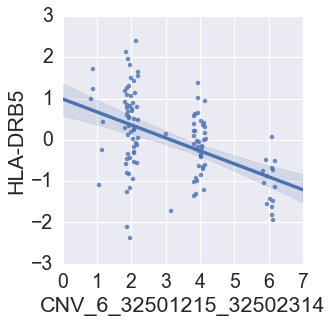

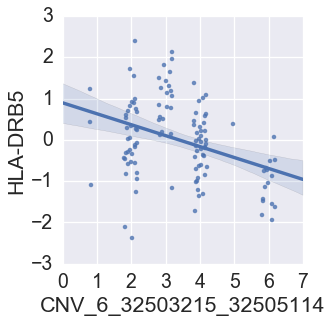

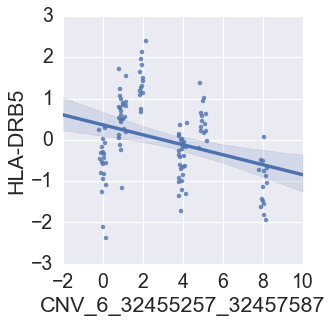

In [41]:
plot_results(sig.gene.drop_duplicates().values[10])

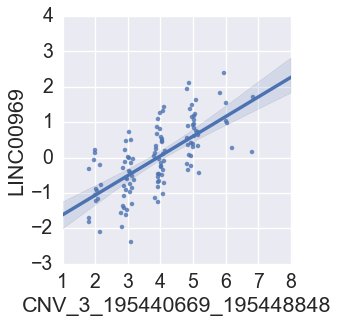

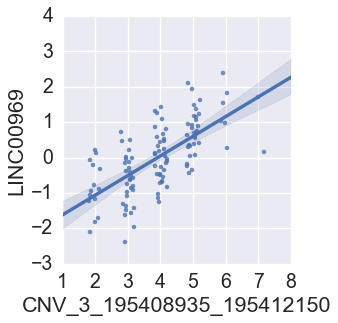

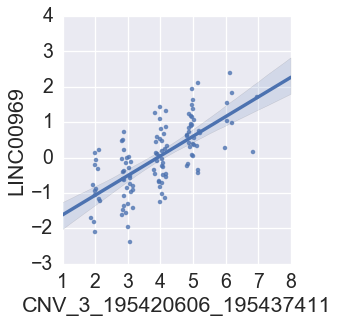

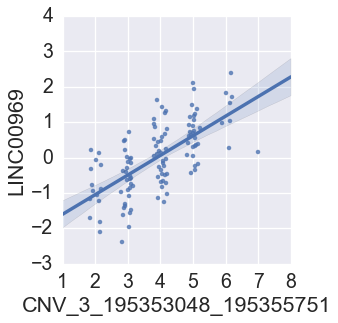

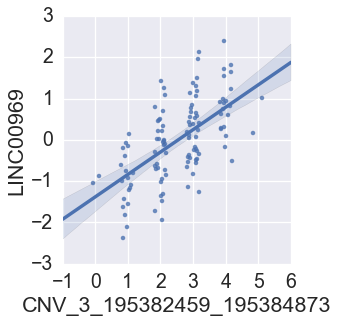

In [42]:
plot_results(sig.gene.drop_duplicates().values[15])

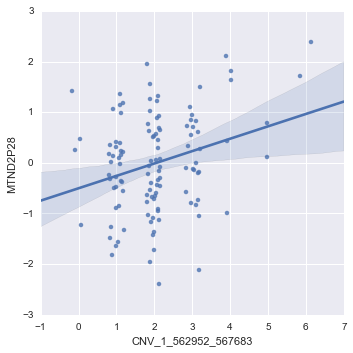

In [68]:
plot_results(sig.gene.drop_duplicates().values[20])

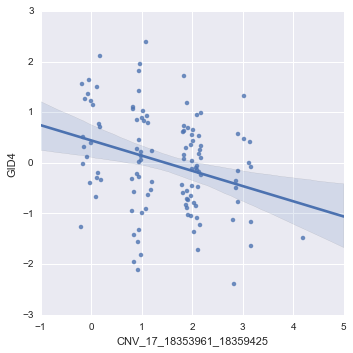

In [69]:
plot_results(sig.gene.drop_duplicates().values[25])

In [49]:
gene_info.ix[set(sig.gene), 'gene_type'].value_counts()

protein_coding          43
pseudogene              32
lincRNA                 13
antisense                6
processed_transcript     3
sense_intronic           1
Name: gene_type, dtype: int64

In [73]:
gene_info.ix[set(sig.gene), 'chrom'].value_counts()

chr17    23
chr1     14
chr8     11
chr7     11
chr10     9
chr6      7
chr5      6
chr9      5
chr15     3
chr16     3
chr3      3
chr2      2
chr12     1
Name: chrom, dtype: int64

In [114]:
g = 'ENSG00000228696.4'
t = sig[sig.gene == g]

In [115]:
t.shape

(9, 10)

In [117]:
s = '\n'.join(t.chrom + '\t' + t.start.astype(str) + '\t' + t.end.astype(str)) + '\n'
bt = pbt.BedTool(s, from_string=True)
bt = bt.sort()

In [118]:
len(bt)

9

In [119]:
btm = bt.merge()

In [120]:
len(btm)

8

In [121]:
print(btm)

chr17	43650217	43662029
chr17	44282354	44285887
chr17	44316953	44319271
chr17	44338657	44341184
chr17	44342314	44353317
chr17	44358539	44363195
chr17	44364249	44367851
chr17	44566797	44569598



In [130]:
sig.head()

,beta,cnv,gene,pvalue,bh_pvalue,bh_sig,chrom,start,end,length
1455,0.256130,CNV_6_32530761_32533960,ENSG00000204308.6,3.756620e-03,4.880612e-02,True,chr6,32530761,32533960,3199
1904,0.792371,CNV_6_32530761_32533960,ENSG00000196126.6,2.032134e-30,1.656698e-27,True,chr6,32530761,32533960,3199
2303,0.284410,CNV_6_32530761_32533960,ENSG00000204463.8,1.181395e-03,1.850486e-02,True,chr6,32530761,32533960,3199
3701,0.559264,CNV_6_32530761_32533960,ENSG00000204287.9,6.402819e-12,3.509175e-10,True,chr6,32530761,32533960,3199
4596,0.623682,CNV_6_32530761_32533960,ENSG00000179344.12,2.638063e-15,2.263875e-13,True,chr6,32530761,32533960,3199


In [138]:
sig.overlap_gene.value_counts()

False    433
True      71
Name: overlap_gene, dtype: int64

In [140]:
sum(sig.ix[sig.overlap_gene, 'beta'] > 0)

66

In [141]:
len(set(sig.gene))

98

In [145]:
len(set(sig.ix[sig.overlap_gene, 'gene']))

24

In [187]:
tt = sig[sig.overlap_gene]

In [189]:
tt = tt.sort_values(by=['beta'], ascending=False)

In [190]:
tt = tt.drop_duplicates(subset=['gene'])

In [191]:
sum(tt.beta > 0)

22

In [193]:
r = list(sig.ix[sig.overlap_gene, 'gene'])

In [194]:
t = sig[sig.gene.apply(lambda x: x not in r)]

In [195]:
t['dist_to_gene_abs'] = t.dist_to_gene.abs()

In [197]:
t.sort_values(by=['dist_to_gene_abs'], inplace=True)

In [199]:
t = t.drop_duplicates(subset=['gene'])

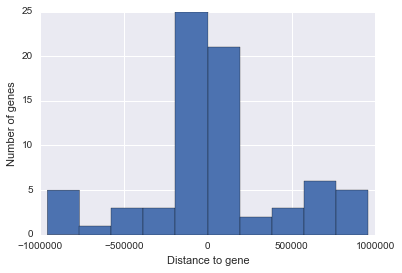

In [204]:
t.dist_to_gene.plot(kind='hist')
plt.ylabel('Number of genes')
plt.xlabel('Distance to gene');

In [205]:
sum(t.dist_to_gene_abs < 100000)

40